<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S6/mnist_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

## Setting up Dataloaders and Transformations


In [2]:
def transformations(augmentation=False, rotation=0.0):
    transforms_list = [
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                    ]

    if augmentation:
        transforms_list = [
                           transforms.RandomRotation((-rotation, rotation), fill=(1,))
                        ] + transforms_list
    
    return transforms.Compose(transforms_list)


def data_loader(data, batch_size, cuda, num_workers):
    args = {
        'shuffle': True,
        'batch_size': batch_size
    }

    if cuda:
        args['num_workers'] = num_workers
        args['pin_memory'] = True
    
    return torch.utils.data.DataLoader(data, **args)

In [3]:
torch.manual_seed(123)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_transforms = transformations(augmentation=True, rotation=6.0)
test_transforms = transformations()

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = data_loader(train_set, 64, use_cuda, num_workers=4)
test_loader = data_loader(test_set, 64, use_cuda, num_workers=4)


## Ghost Batch Normalisation - layer construction

In [4]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            # print(N, C, H, W)
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

## Making our model

In [5]:
# dropout_rate = 0.02

class GBNnet(nn.Module):
    def __init__(self, dropout_rate=0.02):
        super(GBNnet, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias=False), # RF - 3x3
            GhostBatchNorm(10, 4),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 3x3

            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            GhostBatchNorm(10, 4),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 5x5

            nn.MaxPool2d(2, 2), # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, bias=False), # RF - 12x12
            GhostBatchNorm(16, 4),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 12x12

            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            GhostBatchNorm(16, 4),
            nn.ReLU(), 
            nn.Dropout2d(self.dropout_rate), # RF - 14x14

            nn.MaxPool2d(2, 2), # RF - 28x28

            nn.Conv2d(16, 10, 3, bias=False), # RF - 30x30
            GhostBatchNorm(10, 4),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate) # RF - 30x30

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 1, bias=False), # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=[-2,-1]) # GAP Layer

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [6]:
# dropout_rate = 0.02

class BNnet(nn.Module):
    def __init__(self, dropout_rate=0.02):
        super(BNnet, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias=False), # RF - 3x3
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 3x3
            
            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 5x5

            nn.MaxPool2d(2, 2), # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, bias=False), # RF - 12x12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate), # RF - 12x12

            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.Dropout2d(self.dropout_rate), # RF - 14x14

            nn.MaxPool2d(2, 2), # RF - 28x28

            nn.Conv2d(16, 10, 3, bias=False), # RF - 30x30
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate) # RF - 30x30

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 1, bias=False), # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=[-2,-1]) # GAP Layer

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [7]:
# Model summary if required

# model = BNnet().to(device)
# summary(model, input_size=(1, 28, 28))

## Defining the optimizers and losses

In [8]:
def sgd_optimizer(model, lr=0.01, l2_factor=0, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_factor)


def calculate_l1_loss(model, loss, lambda_l1=0.001):
    l1_regularization = 0.
    for param in model.parameters():
        l1_regularization += param.abs().sum()
    loss = loss + lambda_l1*l1_regularization
    return loss

## Setting up the trainer class

Consisting of training and validation loop.

In [9]:
from tqdm import tqdm

class Trainer():
    def __init__(self, model, optimizer, criterion, data_loader, valid_data_loader=None, lr_scheduler=None, l1_loss=False, l1_factor=0.001):
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = model.to(self.device)

        self.train_loader, self.test_loader = data_loader, valid_data_loader
        self.do_validation = True if self.test_loader else False

        self.lr_scheduler = lr_scheduler

        self.l1_loss = l1_loss
        self.l1_factor = l1_factor
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train(self, epochs):
        results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [],}
        for epoch in range(1, epochs+1):
            print(f"------------ EPOCH {epoch} -------------")
            result = self._train_epoch()
            for k,v in result.items():
                results[k].append(v)

        return results

    def _train_epoch(self):
        log = {'train_loss': 0, 'train_acc': 0}
        self.model.train()
        pbar = tqdm(self.train_loader, position=0, leave=True)
        correct = 0
        processed = 0
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()

            output = self.model(data)
            loss = calculate_l1_loss(self.model, self.criterion(output, target), self.l1_factor) if self.l1_loss else self.criterion(output, target)

            log['train_loss'] = loss
            loss.backward()
            self.optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            log['train_acc'] = 100*correct/processed

        if self.lr_scheduler is not None:
            self.lr_scheduler.step()

        if self.do_validation:
            val_log = self._valid_epoch()
            log.update(val_log)
    
        return log
    
    def _valid_epoch(self):
        val_log = {'test_loss': 0, 'test_acc': 0}
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += calculate_l1_loss(self.model, self.criterion(output, target, reduction='sum'), self.l1_factor).item() if self.l1_loss else self.criterion(output, target, reduction='sum').item()  # sum up batch loss

                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        val_log['test_loss'] = test_loss

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(self.test_loader.dataset), 100. * correct / len(self.test_loader.dataset)))
        val_log['test_acc'] = 100. * correct / len(self.test_loader.dataset)

        return val_log

    def save(self, name):
        torch.save(self.model.state_dict(), f'{name}.pt')

In [10]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


## Instantiating and Training models

In [11]:
criterion = F.nll_loss
results = {}

In [13]:
BN_l1 = BNnet()
optimizer_BN_l1 = sgd_optimizer(BN_l1, l2_factor=0)
scheduler_BN_l1 = StepLR(optimizer_BN_l1, step_size=4, gamma=0.15)
trainer = Trainer(BN_l1, optimizer_BN_l1, criterion, train_loader, test_loader, lr_scheduler=scheduler_BN_l1, l1_loss=True, l1_factor=0.001)
results['BN_l1'] = trainer.train(25)
trainer.save('BN_l1')

  0%|          | 0/938 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.710323691368103 Batch_id=937 Accuracy=88.69: 100%|██████████| 938/938 [00:21<00:00, 44.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9738/10000 (97%)

------------ EPOCH 2 -------------


Loss=0.5312758684158325 Batch_id=937 Accuracy=95.01: 100%|██████████| 938/938 [00:20<00:00, 44.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9828/10000 (98%)

------------ EPOCH 3 -------------


Loss=0.29885560274124146 Batch_id=937 Accuracy=95.53: 100%|██████████| 938/938 [00:21<00:00, 43.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9797/10000 (98%)

------------ EPOCH 4 -------------


Loss=0.36104118824005127 Batch_id=937 Accuracy=95.62: 100%|██████████| 938/938 [00:20<00:00, 44.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9844/10000 (98%)

------------ EPOCH 5 -------------


Loss=0.593898594379425 Batch_id=937 Accuracy=96.93: 100%|██████████| 938/938 [00:21<00:00, 44.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9902/10000 (99%)

------------ EPOCH 6 -------------


Loss=0.2156829833984375 Batch_id=937 Accuracy=97.02: 100%|██████████| 938/938 [00:20<00:00, 45.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9903/10000 (99%)

------------ EPOCH 7 -------------


Loss=0.38044413924217224 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:21<00:00, 43.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9892/10000 (99%)

------------ EPOCH 8 -------------


Loss=0.42608338594436646 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [00:21<00:00, 44.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9876/10000 (99%)

------------ EPOCH 9 -------------


Loss=0.305566668510437 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:20<00:00, 45.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9932/10000 (99%)

------------ EPOCH 10 -------------


Loss=0.2640853226184845 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:20<00:00, 45.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9926/10000 (99%)

------------ EPOCH 11 -------------


Loss=0.20692119002342224 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9930/10000 (99%)

------------ EPOCH 12 -------------


Loss=0.24294047057628632 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:21<00:00, 44.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9919/10000 (99%)

------------ EPOCH 13 -------------


Loss=0.2591957449913025 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:20<00:00, 44.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9928/10000 (99%)

------------ EPOCH 14 -------------


Loss=0.2024616301059723 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:20<00:00, 45.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9924/10000 (99%)

------------ EPOCH 15 -------------


Loss=0.23297333717346191 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:20<00:00, 45.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9926/10000 (99%)

------------ EPOCH 16 -------------


Loss=0.2148583084344864 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:20<00:00, 45.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9930/10000 (99%)

------------ EPOCH 17 -------------


Loss=0.1882568895816803 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:20<00:00, 45.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9925/10000 (99%)

------------ EPOCH 18 -------------


Loss=0.22658011317253113 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:20<00:00, 44.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9930/10000 (99%)

------------ EPOCH 19 -------------


Loss=0.18244600296020508 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:20<00:00, 45.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9929/10000 (99%)

------------ EPOCH 20 -------------


Loss=0.24449628591537476 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:21<00:00, 44.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9925/10000 (99%)

------------ EPOCH 21 -------------


Loss=0.23424577713012695 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:21<00:00, 44.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9928/10000 (99%)

------------ EPOCH 22 -------------


Loss=0.17458537220954895 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:20<00:00, 45.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9929/10000 (99%)

------------ EPOCH 23 -------------


Loss=0.16659347712993622 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:20<00:00, 45.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9924/10000 (99%)

------------ EPOCH 24 -------------


Loss=0.2551448345184326 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:20<00:00, 44.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9928/10000 (99%)

------------ EPOCH 25 -------------


Loss=0.3313290774822235 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:20<00:00, 44.93it/s]



Test set: Average loss: 0.0294, Accuracy: 9928/10000 (99%)



In [14]:
BN_l2 = BNnet()
optimizer_BN_l2 = sgd_optimizer(BN_l2, l2_factor=0.0004)
scheduler_BN_l2 = StepLR(optimizer_BN_l2, step_size=4, gamma=0.15)
trainer = Trainer(BN_l2, optimizer_BN_l2, criterion, train_loader, test_loader, lr_scheduler=scheduler_BN_l2, l1_loss=False)
results['BN_l2'] = trainer.train(25)
trainer.save('BN_l2')

  0%|          | 0/938 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.06860796362161636 Batch_id=937 Accuracy=89.23: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9855/10000 (99%)

------------ EPOCH 2 -------------


Loss=0.08040235191583633 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:19<00:00, 48.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9899/10000 (99%)

------------ EPOCH 3 -------------


Loss=0.06729725003242493 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9905/10000 (99%)

------------ EPOCH 4 -------------


Loss=0.06867746263742447 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:19<00:00, 48.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99%)

------------ EPOCH 5 -------------


Loss=0.03467969223856926 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:19<00:00, 49.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9931/10000 (99%)

------------ EPOCH 6 -------------


Loss=0.03540515527129173 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:19<00:00, 48.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99%)

------------ EPOCH 7 -------------


Loss=0.1834700107574463 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:19<00:00, 48.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9929/10000 (99%)

------------ EPOCH 8 -------------


Loss=0.022137867286801338 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:19<00:00, 49.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99%)

------------ EPOCH 9 -------------


Loss=0.022419780492782593 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:19<00:00, 49.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99%)

------------ EPOCH 10 -------------


Loss=0.04066940397024155 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99%)

------------ EPOCH 11 -------------


Loss=0.024431664496660233 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:19<00:00, 48.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9934/10000 (99%)

------------ EPOCH 12 -------------


Loss=0.0016138271894305944 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:19<00:00, 47.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99%)

------------ EPOCH 13 -------------


Loss=0.04760231450200081 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:19<00:00, 47.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99%)

------------ EPOCH 14 -------------


Loss=0.07007189095020294 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99%)

------------ EPOCH 15 -------------


Loss=0.03853758051991463 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99%)

------------ EPOCH 16 -------------


Loss=0.03116200864315033 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:19<00:00, 47.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99%)

------------ EPOCH 17 -------------


Loss=0.08413270115852356 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:19<00:00, 48.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99%)

------------ EPOCH 18 -------------


Loss=0.12273945659399033 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:19<00:00, 48.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99%)

------------ EPOCH 19 -------------


Loss=0.28064411878585815 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:19<00:00, 49.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99%)

------------ EPOCH 20 -------------


Loss=0.01826268993318081 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:19<00:00, 47.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99%)

------------ EPOCH 21 -------------


Loss=0.02969985641539097 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:18<00:00, 49.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99%)

------------ EPOCH 22 -------------


Loss=0.04074912890791893 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:19<00:00, 48.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99%)

------------ EPOCH 23 -------------


Loss=0.007766323629766703 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99%)

------------ EPOCH 24 -------------


Loss=0.061239201575517654 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99%)

------------ EPOCH 25 -------------


Loss=0.0187978632748127 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]



Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99%)



In [15]:
BN_l1_l2 = BNnet()
optimizer_BN_l1_l2 = sgd_optimizer(BN_l1_l2, l2_factor=0.0004)
scheduler_BN_l1_l2 = StepLR(optimizer_BN_l1_l2, step_size=4, gamma=0.15)
trainer = Trainer(BN_l1_l2, optimizer_BN_l1_l2, criterion, train_loader, test_loader, lr_scheduler=scheduler_BN_l1_l2, l1_loss=True, l1_factor=0.001)
results['BN_l1_l2'] = trainer.train(25)
trainer.save('BN_l1_l2')

  0%|          | 0/938 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.5833847522735596 Batch_id=937 Accuracy=89.63: 100%|██████████| 938/938 [00:21<00:00, 44.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0954, Accuracy: 9774/10000 (98%)

------------ EPOCH 2 -------------


Loss=0.30788660049438477 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:21<00:00, 43.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 9810/10000 (98%)

------------ EPOCH 3 -------------


Loss=0.3252997100353241 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [00:21<00:00, 43.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9835/10000 (98%)

------------ EPOCH 4 -------------


Loss=0.34590160846710205 Batch_id=937 Accuracy=95.81: 100%|██████████| 938/938 [00:21<00:00, 44.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1041, Accuracy: 9699/10000 (97%)

------------ EPOCH 5 -------------


Loss=0.2552275061607361 Batch_id=937 Accuracy=96.97: 100%|██████████| 938/938 [00:21<00:00, 44.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9903/10000 (99%)

------------ EPOCH 6 -------------


Loss=0.37674248218536377 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:21<00:00, 44.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9903/10000 (99%)

------------ EPOCH 7 -------------


Loss=0.38072049617767334 Batch_id=937 Accuracy=97.07: 100%|██████████| 938/938 [00:21<00:00, 44.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9896/10000 (99%)

------------ EPOCH 8 -------------


Loss=0.21452151238918304 Batch_id=937 Accuracy=96.85: 100%|██████████| 938/938 [00:21<00:00, 44.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9900/10000 (99%)

------------ EPOCH 9 -------------


Loss=0.2703574299812317 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:21<00:00, 44.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9904/10000 (99%)

------------ EPOCH 10 -------------


Loss=0.23996050655841827 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:21<00:00, 44.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9904/10000 (99%)

------------ EPOCH 11 -------------


Loss=0.37882429361343384 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:20<00:00, 44.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9917/10000 (99%)

------------ EPOCH 12 -------------


Loss=0.18289290368556976 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:21<00:00, 43.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9914/10000 (99%)

------------ EPOCH 13 -------------


Loss=0.32802194356918335 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:21<00:00, 44.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9921/10000 (99%)

------------ EPOCH 14 -------------


Loss=0.18767577409744263 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:22<00:00, 42.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9911/10000 (99%)

------------ EPOCH 15 -------------


Loss=0.27180540561676025 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:22<00:00, 42.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9915/10000 (99%)

------------ EPOCH 16 -------------


Loss=0.19951403141021729 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:21<00:00, 43.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9918/10000 (99%)

------------ EPOCH 17 -------------


Loss=0.17653344571590424 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:21<00:00, 44.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9918/10000 (99%)

------------ EPOCH 18 -------------


Loss=0.17517736554145813 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:20<00:00, 45.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9918/10000 (99%)

------------ EPOCH 19 -------------


Loss=0.23037245869636536 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:21<00:00, 43.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9919/10000 (99%)

------------ EPOCH 20 -------------


Loss=0.2287338674068451 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:22<00:00, 42.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9918/10000 (99%)

------------ EPOCH 21 -------------


Loss=0.17865902185440063 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:21<00:00, 44.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9919/10000 (99%)

------------ EPOCH 22 -------------


Loss=0.18809622526168823 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:21<00:00, 43.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9919/10000 (99%)

------------ EPOCH 23 -------------


Loss=0.24527224898338318 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:21<00:00, 43.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9919/10000 (99%)

------------ EPOCH 24 -------------


Loss=0.2648531496524811 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:21<00:00, 43.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9922/10000 (99%)

------------ EPOCH 25 -------------


Loss=0.48879653215408325 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:21<00:00, 44.50it/s]



Test set: Average loss: 0.0306, Accuracy: 9918/10000 (99%)





---

Using batch_size = 128 for GBN.


In [22]:
train_loader = data_loader(train_set, 128, use_cuda, num_workers=4)
test_loader = data_loader(test_set, 128, use_cuda, num_workers=4)

In [23]:
GBN = GBNnet()
optimizer_GBN = sgd_optimizer(GBN, l2_factor=0)
scheduler_GBN = StepLR(optimizer_GBN, step_size=4, gamma=0.15)
trainer = Trainer(GBN, optimizer_GBN, criterion, train_loader, test_loader, lr_scheduler=scheduler_GBN, l1_loss=False)
results['GBN'] = trainer.train(25)
trainer.save('GBN')

  0%|          | 0/469 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.10296100378036499 Batch_id=468 Accuracy=84.55: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0780, Accuracy: 9809/10000 (98%)

------------ EPOCH 2 -------------


Loss=0.21124374866485596 Batch_id=468 Accuracy=95.70: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9875/10000 (99%)

------------ EPOCH 3 -------------


Loss=0.06669733673334122 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9899/10000 (99%)

------------ EPOCH 4 -------------


Loss=0.2661075294017792 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9909/10000 (99%)

------------ EPOCH 5 -------------


Loss=0.11783679574728012 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99%)

------------ EPOCH 6 -------------


Loss=0.12251687794923782 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9916/10000 (99%)

------------ EPOCH 7 -------------


Loss=0.04932823404669762 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99%)

------------ EPOCH 8 -------------


Loss=0.0448843277990818 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9911/10000 (99%)

------------ EPOCH 9 -------------


Loss=0.14501789212226868 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99%)

------------ EPOCH 10 -------------


Loss=0.02674000710248947 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9913/10000 (99%)

------------ EPOCH 11 -------------


Loss=0.19986288249492645 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99%)

------------ EPOCH 12 -------------


Loss=0.015461872331798077 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99%)

------------ EPOCH 13 -------------


Loss=0.06722419708967209 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99%)

------------ EPOCH 14 -------------


Loss=0.045964960008859634 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99%)

------------ EPOCH 15 -------------


Loss=0.054267823696136475 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99%)

------------ EPOCH 16 -------------


Loss=0.051129087805747986 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99%)

------------ EPOCH 17 -------------


Loss=0.06804804503917694 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99%)

------------ EPOCH 18 -------------


Loss=0.030003182590007782 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99%)

------------ EPOCH 19 -------------


Loss=0.07018585503101349 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99%)

------------ EPOCH 20 -------------


Loss=0.04585042968392372 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9917/10000 (99%)

------------ EPOCH 21 -------------


Loss=0.13601596653461456 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99%)

------------ EPOCH 22 -------------


Loss=0.12617962062358856 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99%)

------------ EPOCH 23 -------------


Loss=0.05397133529186249 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99%)

------------ EPOCH 24 -------------


Loss=0.10409273952245712 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9921/10000 (99%)

------------ EPOCH 25 -------------


Loss=0.08843100816011429 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]



Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99%)



In [24]:
GBN_l1_l2 = GBNnet()
optimizer_GBN_l1_l2 = sgd_optimizer(GBN_l1_l2, l2_factor=0.0004)
scheduler_GBN_l1_l2 = StepLR(optimizer_GBN_l1_l2, step_size=4, gamma=0.15)
trainer = Trainer(GBN_l1_l2, optimizer_GBN_l1_l2, criterion, train_loader, test_loader, lr_scheduler=scheduler_GBN_l1_l2, l1_loss=True, l1_factor=0.001)
results['GBN_l1_l2'] = trainer.train(25)
trainer.save('GBN_l1_l2')

  0%|          | 0/469 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.5380386114120483 Batch_id=468 Accuracy=85.97: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1410, Accuracy: 9694/10000 (97%)

------------ EPOCH 2 -------------


Loss=0.4036768078804016 Batch_id=468 Accuracy=94.80: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9788/10000 (98%)

------------ EPOCH 3 -------------


Loss=0.4034462571144104 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0888, Accuracy: 9777/10000 (98%)

------------ EPOCH 4 -------------


Loss=0.39019784331321716 Batch_id=468 Accuracy=95.55: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Accuracy: 9818/10000 (98%)

------------ EPOCH 5 -------------


Loss=0.26756516098976135 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9910/10000 (99%)

------------ EPOCH 6 -------------


Loss=0.381072461605072 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9913/10000 (99%)

------------ EPOCH 7 -------------


Loss=0.33407628536224365 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9896/10000 (99%)

------------ EPOCH 8 -------------


Loss=0.2886340916156769 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9906/10000 (99%)

------------ EPOCH 9 -------------


Loss=0.3434050381183624 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9924/10000 (99%)

------------ EPOCH 10 -------------


Loss=0.26005467772483826 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9928/10000 (99%)

------------ EPOCH 11 -------------


Loss=0.23252150416374207 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9930/10000 (99%)

------------ EPOCH 12 -------------


Loss=0.31507569551467896 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9928/10000 (99%)

------------ EPOCH 13 -------------


Loss=0.24448415637016296 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9926/10000 (99%)

------------ EPOCH 14 -------------


Loss=0.2929472327232361 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9926/10000 (99%)

------------ EPOCH 15 -------------


Loss=0.2734580636024475 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9925/10000 (99%)

------------ EPOCH 16 -------------


Loss=0.27027180790901184 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9931/10000 (99%)

------------ EPOCH 17 -------------


Loss=0.22585612535476685 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9926/10000 (99%)

------------ EPOCH 18 -------------


Loss=0.2391585409641266 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9931/10000 (99%)

------------ EPOCH 19 -------------


Loss=0.28367647528648376 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9933/10000 (99%)

------------ EPOCH 20 -------------


Loss=0.2673783302307129 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9929/10000 (99%)

------------ EPOCH 21 -------------


Loss=0.19857670366764069 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9930/10000 (99%)

------------ EPOCH 22 -------------


Loss=0.26186347007751465 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9930/10000 (99%)

------------ EPOCH 23 -------------


Loss=0.3096574544906616 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9929/10000 (99%)

------------ EPOCH 24 -------------


Loss=0.2407892644405365 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9930/10000 (99%)

------------ EPOCH 25 -------------


Loss=0.27839115262031555 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]



Test set: Average loss: 0.0290, Accuracy: 9930/10000 (99%)



## Plotting results

In [25]:
def plot_metric(results, metric):
    # Initialize a figure
    fig = plt.figure(figsize=(13, 11))

    for name, values in results.items():
        plt.plot(range(1, len(values) + 1), values, '.-', label=name)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if metric.lower() == 'loss' else 'lower'
    plt.legend(loc=f'{location} right', 
               shadow=True, 
               prop={'size': 20},
               )

    # Save plot
    plt.show()
    fig.savefig(f'{metric.lower()}.png')

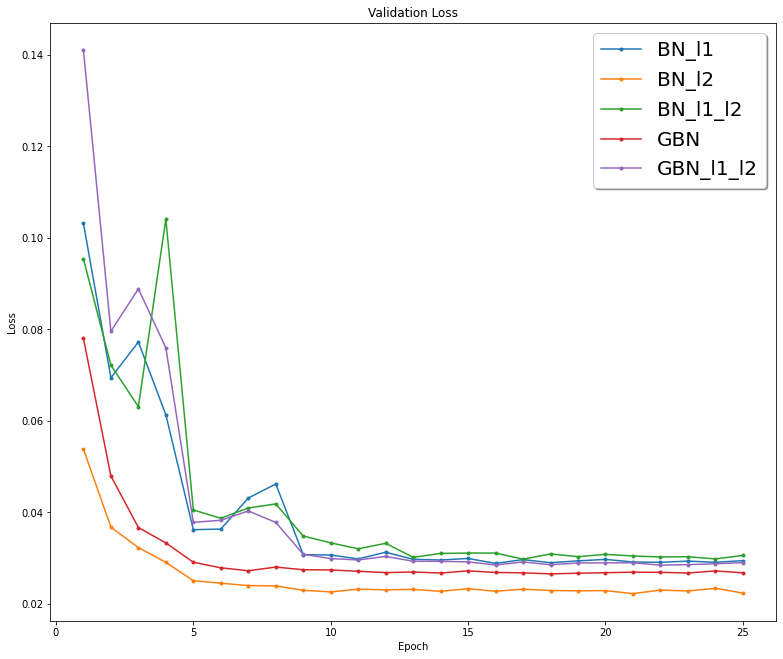

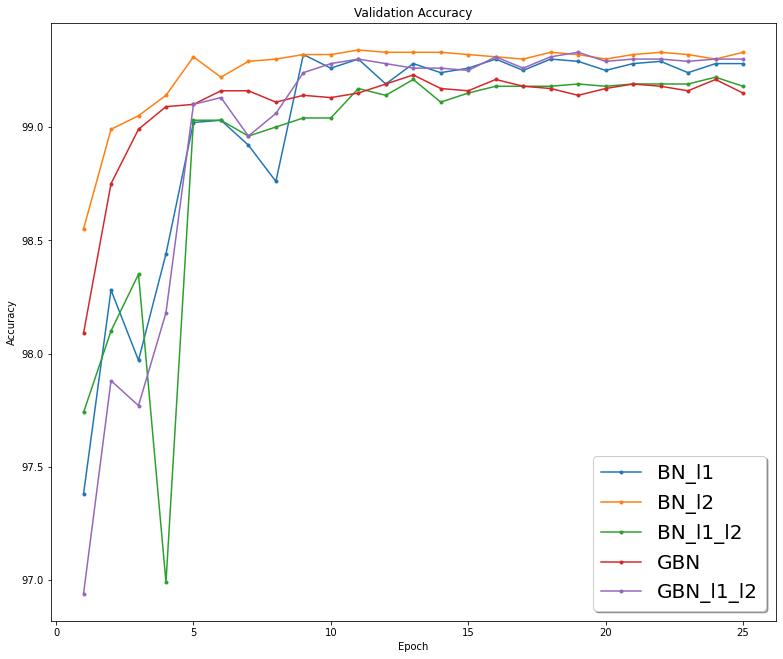

In [26]:
# Validation loss
losses = {}
accuracies = {}
for k, v in results.items():
    losses[k] = v['test_loss']
    accuracies[k] = v['test_acc']

plot_metric(losses, 'Loss')
plot_metric(accuracies, 'Accuracy')

## Identifying and plotting misclassified images

In [55]:
def identify_misclassification(model, model_path, test_loader, limit=25):
    incorrect_samples = []

    # identifying device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load the model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Identify misclassified images
    with torch.no_grad():
        for data, target in test_loader:
            images = data
            data, target = data.to(device), target.to(device)
            output = model(data)

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            result = pred.eq(target.view_as(pred))

            # Save incorrect samples
            if len(incorrect_samples) < limit:
                for i in range(test_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(pred)[i],
                            'label': list(target.view_as(pred))[i],
                            'image': list(images)[i]
                        })

    return incorrect_samples


def plot_results(data):

    # Initialize plot
    row_count = -1
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    fig.tight_layout()

    for idx, result in enumerate(data):
        if idx > 24:
            break
        
        label = result['label'].item()
        prediction = result['prediction'].item()

        # Plot image
        if idx % 5 == 0:
            row_count += 1
        axs[row_count][idx % 5].axis('off')
        axs[row_count][idx % 5].set_title(f'Label: {label}\nPrediction: {prediction}')
        axs[row_count][idx % 5].imshow(result['image'][0], cmap='gray_r')
    
    plt.show()
    fig.savefig(f'incorrect_predictions.png', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


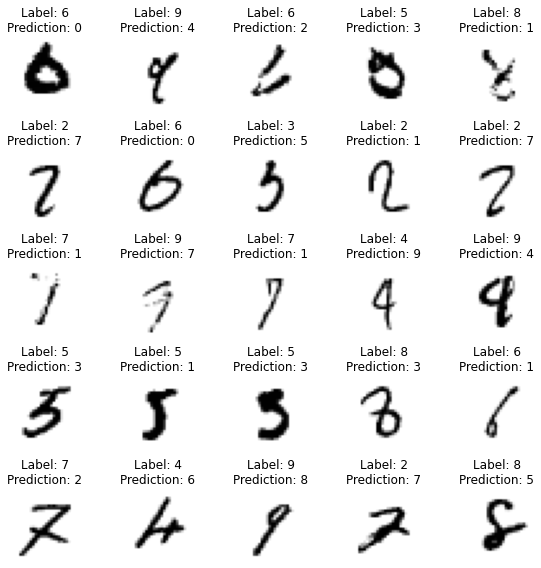

In [56]:
incorrect_samples = identify_misclassification(GBNnet(), '/content/GBN.pt', test_loader)
# incorrect_samples
plot_results(incorrect_samples)